In [ ]:
'''
Alex Costanzino, Marco Costante
MSc student in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
March, 2021
'''

## Import and parameters

In [1]:
# Doc: https://segmentation-models.readthedocs.io/
!pip install -U segmentation-models

     |████████████████████████████████| 51kB 4.7MB/s 


In [2]:
%env SM_FRAMEWORK = tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
import os
import random

import numpy as np
import tensorflow as tf

import keras
import segmentation_models

from tqdm import tqdm
from pycocotools.coco import COCO
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Segmentation Models: using `tf.keras` framework.


In [4]:
''' Upload files from the drive '''
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
'''Image parameters'''
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3

CLASSES = 18 # 16 categories + background + other categories

# Loading data

In [6]:
'''Loading annotations file for the training set'''
annFile = '/content/drive/MyDrive/deep_learning_project/train/annotations.json'
coco_train = COCO(annFile)

loading annotations into memory...
Done (t=5.51s)
creating index...
index created!


In [7]:
'''Display COCO categories'''
cats = coco_train.loadCats(coco_train.getCatIds())
nms = [cat['name'] for cat in cats]

print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
water pear egg grapes butter bread-white jam bread-whole-wheat apple tea-green white-coffee-with-caffeine tea-black mixed-salad-chopped-without-sauce cheese tomato-sauce pasta-spaghetti carrot onion beef-cut-into-stripes-only-meat rice-noodles-vermicelli salad-leaf-salad-green bread-grain espresso-with-caffeine banana mixed-vegetables bread-wholemeal savoury-puff-pastry wine-white dried-meat fresh-cheese red-radish hard-cheese ham-raw bread-fruit oil-vinegar-salad-dressing tomato cauliflower potato-gnocchi wine-red sauce-cream pasta-linguini-parpadelle-tagliatelle french-beans almonds dark-chocolate mandarine semi-hard-cheese croissant sushi berries biscuits thickened-cream-35 corn celeriac alfa-sprouts chickpeas leaf-spinach rice chocolate-cookies pineapple tart coffee-with-caffeine focaccia pizza-with-vegetables-baked soup-vegetable bread-toast potatoes-steamed spaetzle frying-sausage lasagne-meat-prepared boisson-au-glucose-50g ma1-4esli peanut-butter chips-french-

In [8]:
'''Getting all categories with respect to their total images and showing the 16 most frequent categories'''
no_images_per_category = {}

for n, i in enumerate(coco_train.getCatIds()):
    imgIds = coco_train.getImgIds(catIds=i)
    label = nms[n]
    no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(coco_train.loadImgs(coco_train.getImgIds()))

'''Most frequent categories'''
categories = pd.DataFrame(no_images_per_category.items()).sort_values(1).iloc[::-1][0][:30].tolist()[0:16]
print(categories)

'''Dict with most frequent categories, the ones we chose'''
category_channels = dict(zip(categories, range(1, len(categories) + 1)))
print(category_channels)

['water', 'bread-white', 'salad-leaf-salad-green', 'tomato', 'butter', 'bread-wholemeal', 'carrot', 'coffee-with-caffeine', 'rice', 'egg', 'mixed-vegetables', 'wine-red', 'apple', 'jam', 'potatoes-steamed', 'banana']
{'water': 1, 'bread-white': 2, 'salad-leaf-salad-green': 3, 'tomato': 4, 'butter': 5, 'bread-wholemeal': 6, 'carrot': 7, 'coffee-with-caffeine': 8, 'rice': 9, 'egg': 10, 'mixed-vegetables': 11, 'wine-red': 12, 'apple': 13, 'jam': 14, 'potatoes-steamed': 15, 'banana': 16}


In [9]:
'''Extraction of COCO annotations for the selected categories''' 

image_directory = '/content/drive/MyDrive/deep_learning_project/train_reduced/images/'

folder_cats = os.listdir(image_directory)

coco_imgs_train = []

for i, folder in tqdm(enumerate(folder_cats), total = len(folder_cats), position = 0, leave = True):
    if not folder.startswith('.'):
        images_train = os.listdir(image_directory + folder)
    for image_name in images_train:
        imgId = int(coco_train.getImgIds(imgIds = [image_name.split('.')[0]])[0].lstrip("0"))
        coco_imgs_train.append(coco_train.loadImgs([imgId])[0])

TRAINING_SET_SIZE = len(coco_imgs_train)

100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


# Generators

In [10]:
'''Creating masks splitted out in channels: each channel corresponds to one category'''

def read_resize_image(coco_img, path):
    
    image = cv2.imread(path + coco_img['file_name'], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))         
    image = np.asarray(image)
    
    return image

def generate_mask(coco_img, coco_annotations):
    annIds = coco_annotations.getAnnIds(imgIds=coco_img['id'], iscrowd = None)
    anns = coco_annotations.loadAnns(annIds)
    mask = np.zeros((coco_img['height'], coco_img['width'], CLASSES), dtype=np.float32)

    # Setting all pixels of the background channel to 1
    mask[:,:,0] = np.ones((coco_img['height'], coco_img['width']), dtype=np.float32)

    for ann in anns:
        catName = [cat['name'] for cat in cats if cat['id'] == ann['category_id']][0]
        if catName in category_channels:
            mask[:,:,category_channels[catName]] = coco_annotations.annToMask(ann)
            mask[:,:,0] -= mask[:,:,category_channels[catName]] 
        else:
            mask[:,:,-1] += coco_annotations.annToMask(ann)

    mask[:,:,0] -= mask[:,:,-1]
    mask[mask < 0] = 0
    mask[mask > 1] = 1
    mask = (cv2.resize(mask, (IMAGE_WIDTH, IMAGE_HEIGHT)))
    
    return mask

def dataset_generator(coco_imgs, path, coco_annotations, cats, category_channels, dataset_size, batch_size):

    batch_features = np.zeros((batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    batch_labels = np.zeros((batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, CLASSES), dtype = np.float64)

    c = 0
    random.shuffle(coco_imgs)

    while True:
        for i in range(c, c + batch_size):

            coco_img = coco_imgs[i]

            batch_features[i - c] = read_resize_image(coco_img, path)
            batch_labels[i - c] = generate_mask(coco_img, coco_annotations)

        c = c + batch_size
        if(c + batch_size >= dataset_size):
            c = 0
            random.shuffle(coco_imgs)

        yield (batch_features, batch_labels)

In [11]:
'''Loading annotations file for the validation set'''
annFile = '/content/drive/MyDrive/deep_learning_project/val/annotations.json'
coco_val = COCO(annFile)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


In [12]:
'''Extraction of COCO annotations for the selected categories in the validation set'''

image_directory = '/content/drive/MyDrive/deep_learning_project/val/images/'

images_val = os.listdir(image_directory)

coco_imgs_val = []

for i, image in tqdm(enumerate(images_val), total = len(images_val), position = 0, leave = True):
        
    imgId = int(coco_val.getImgIds(imgIds = [image.split('.')[0]])[0].lstrip("0"))
    coco_img_val = coco_val.loadImgs([imgId])[0]
    annIds = coco_val.getAnnIds(imgIds=coco_img_val['id'], iscrowd = None)
    anns = coco_val.loadAnns(annIds)

    for ann in anns:
        catName = [cat['name'] for cat in cats if cat['id'] == ann['category_id']][0]
        if catName in category_channels.keys():
            coco_imgs_val.append(coco_val.loadImgs([imgId])[0])
            break

VALIDATION_SET_SIZE = len(coco_imgs_val)

100%|██████████| 1269/1269 [00:00<00:00, 10395.61it/s]


# Loss functions and metrics

## Smoothed Jaccard distance loss

In [13]:
def jaccard_distance(y_true, y_pred, smooth = 100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis = -1)
    union = tf.reduce_sum(y_true + y_pred, axis = -1)

    jac = (intersection + smooth) / (union - intersection + smooth)
    jd =  (1 - jac) * smooth
    
    return tf.reduce_mean(jd)

In [14]:
''' Metrics '''
IoU_metric = segmentation_models.metrics.IOUScore()

F_metric = segmentation_models.metrics.FScore()

''' Losses '''
crossentropy_loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.5, name = 'categorical_crossentropy')

jaccard_loss = segmentation_models.losses.JaccardLoss()

dice_loss = segmentation_models.losses.DiceLoss() 

focal_loss = segmentation_models.losses.CategoricalFocalLoss() # Non ha righe ma la IoU rimane bassa

# Dice + Focal loss
combined_loss = dice_loss + (1 * focal_loss)

# Evaluation
For a known ground truth mask A, you propose a mask B, then we first compute IoU (Intersection Over Union).

IoU measures the overall overlap between the true region and the proposed region. Then we consider it a **true detection** when there is at least half an overlap, namely when IoU > 0.5

Then we can define the following parameters :
* Precision (IoU > 0.5);
* Recall (IoU > 0.5).

The final scoring parameters: 
* AP{IoU > 0.5};  
* AR{IoU > 0.5};

are computed by averaging over all the precision and recall values for all known annotations in the ground truth.

Guide 1: https://www.jeremyjordan.me/evaluating-image-segmentation-models/

Guide 2: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [34]:
'''Generator initialization'''
path_val = "/content/drive/MyDrive/deep_learning_project/val/images/"

gen_val = dataset_generator(coco_imgs = coco_imgs_val, 
                            path = path_val, 
                            coco_annotations = coco_val, 
                            cats = cats, 
                            category_channels = category_channels, 
                            dataset_size = VALIDATION_SET_SIZE, 
                            batch_size = VALIDATION_SET_SIZE) 

model = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_project/trained_models/[dA]-model_for_segmentation_deep-modella-128-32-jaccard_distance.h5',
                                   custom_objects = {'jaccard_distance': jaccard_distance})

In [16]:
validation_set = next(gen_val)
images_val_set = validation_set[0] # Images
masks_val_set = validation_set[1]  # Masks

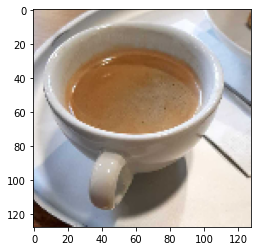

In [30]:
plt.imshow(images_val_set[4].astype(np.uint8))
plt.show()

In [22]:
predictions = model.predict(images_val_set, verbose = 1)

18/18 [==============================] - 89s 5s/step


In [24]:
def show_masks_threshold(prediction):
  labels = list(category_channels.keys())
  labels.insert(0, "background")
  labels.append("other")

  prediction_threshold = prediction.copy()
  prediction_threshold[prediction_threshold >= 0.4] = 1.
  prediction_threshold[prediction_threshold < 0.4] = 0.

  for i in range(CLASSES):
    if np.max(prediction_threshold[:,:,i]) != 0:
      plt.imshow(prediction_threshold[:,:,i])
      plt.title(labels[i])
      plt.show()

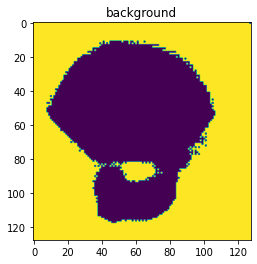

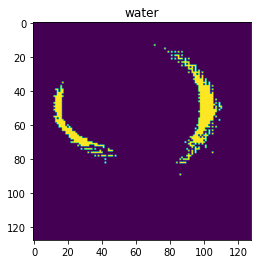

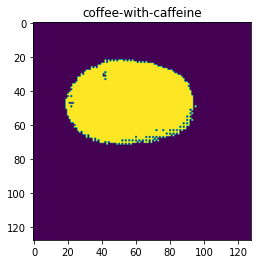

In [31]:
'''Showing the predicted masks'''
show_masks_threshold(predictions[4,:,:,:])

In [32]:
def show_mask_overlapping(prediction):
  labels = list(category_channels.keys())
  labels.insert(0, "background")
  labels.append("other")

  prediction_threshold = prediction.copy()
  prediction_threshold[prediction_threshold >= 0.4] = 1.
  prediction_threshold[prediction_threshold < 0.4] = 0.

  mask_plot = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT), dtype = np.float32)

  '''Preparing the mask with overlapping'''
  for i in range(CLASSES):
    prediction_threshold[:,:,i] = prediction_threshold[:,:,i] * i
    mask_plot += prediction_threshold[:,:,i]
    mask_plot[mask_plot >= i] = i

  values = np.array(np.unique(mask_plot), dtype=np.uint8)
  plt.figure(figsize=(8,4))
  im = plt.imshow(mask_plot, interpolation='none')
  colors = [ im.cmap(im.norm(value)) for value in range(len(labels))]
  patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in values ]
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

  plt.axis('off')
  plt.show()

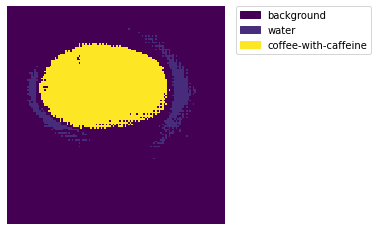

In [33]:
show_mask_overlapping(predictions[4,:,:,:])

In [18]:
'''Computing the IoU, Recall and Precision metrics'''
def compute_results(mean_iou, recall, precision, mask, prediction):
    mean_iou.update_state(mask, prediction)
    recall.update_state(mask, prediction)
    precision.update_state(mask, prediction)

    return recall.result().numpy(), precision.result().numpy(), mean_iou.result().numpy()

mean_iou = tf.keras.metrics.MeanIoU(num_classes = 17)
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

mean_iou_results = []
recall_results = []
precision_results = []

threshold = 0.5

for i in range(VALIDATION_SET_SIZE):
    mask = masks_val_set[i,:,:,:-1]
    prediction = predictions[i,:,:,:-1]

    recall_res, precision_res, mean_iou_res = compute_results(mean_iou, recall, precision, mask, prediction)

    mean_iou_results.append(mean_iou_res)
    mean_iou.reset_states()

    if mean_iou_res >= threshold:

        precision_results.append(precision_res)
        precision.reset_states()

        recall_results.append(recall_res)
        recall.reset_states()

print('Mean precision: {}.'.format(np.average(precision_results)))
print('Mean recall: {}.'.format(np.average(recall_results)))
print('Calculated on {} samples, over {} total samples, that passed the IoU test.'.format(len(np.asarray(mean_iou_results)[np.asarray(mean_iou_results) >= threshold]), VALIDATION_SET_SIZE))
print(mean_iou_results)

Mean precision: 0.7462680339813232.
Mean recall: 0.7162192463874817.
Calculated on 562 samples, over 563 total samples, that passed the IoU test.
[0.8509822, 0.69669026, 0.77131426, 0.77796483, 0.8297411, 0.7176028, 0.9507178, 0.80481875, 0.69968617, 0.757217, 0.80564225, 0.81249464, 0.7551113, 0.904228, 0.7745697, 0.7742144, 0.8316835, 0.8924488, 0.80985653, 0.8419349, 0.8349928, 0.8274504, 0.89771605, 0.735991, 0.5550014, 0.7407019, 0.9014766, 0.57620573, 0.7606244, 0.83660793, 0.71495754, 0.7988196, 0.888576, 0.7912448, 0.88449657, 0.73040724, 0.8736262, 0.9727462, 0.5608876, 0.7500626, 0.849921, 0.7845339, 0.5271884, 0.7771064, 0.719777, 0.7272692, 0.71000063, 0.8479241, 0.7544645, 0.8484138, 0.9139471, 0.72241163, 0.8079879, 0.74223936, 0.9056877, 0.7558985, 0.585036, 0.78304315, 0.85505104, 0.7363921, 0.88778746, 0.8743788, 0.91767025, 0.9393343, 0.6794505, 0.81732136, 0.8198507, 0.88609457, 0.7519253, 0.8434292, 0.82846475, 0.8412291, 0.72266126, 0.7584703, 0.96237385, 0.6933302

In [19]:
print(np.max(mean_iou_results), np.min(mean_iou_results))

0.991513 0.47197375


In [20]:
print(np.mean(mean_iou_results))

0.77898854
